/var/folders/hr/2t7hsj753qg3n1q7zbnr625m0000gn/T/ipykernel_99395/3392635182.py:49: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap(name)  # 获取颜色映射


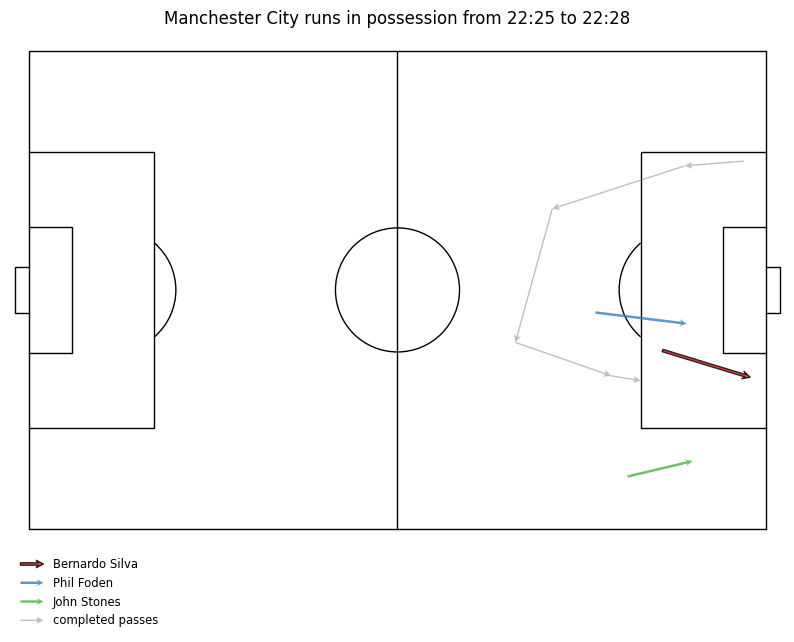

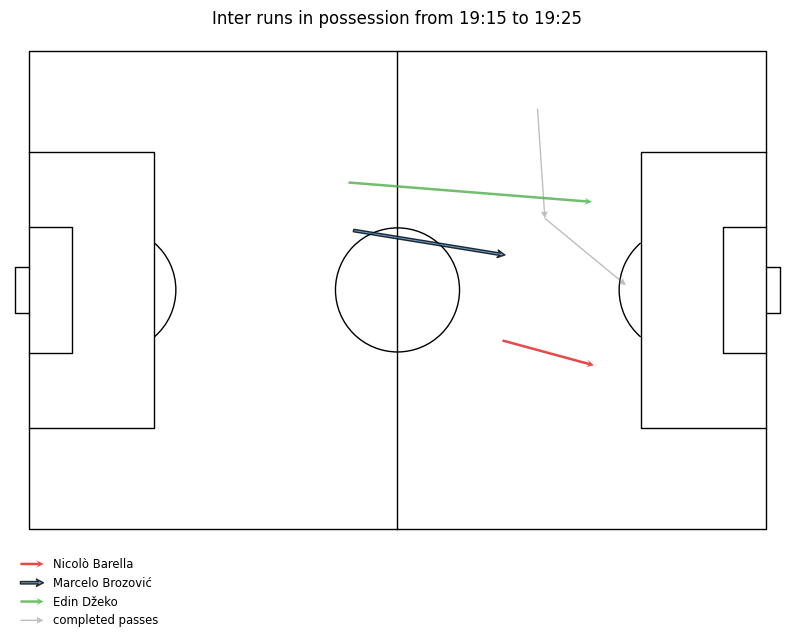

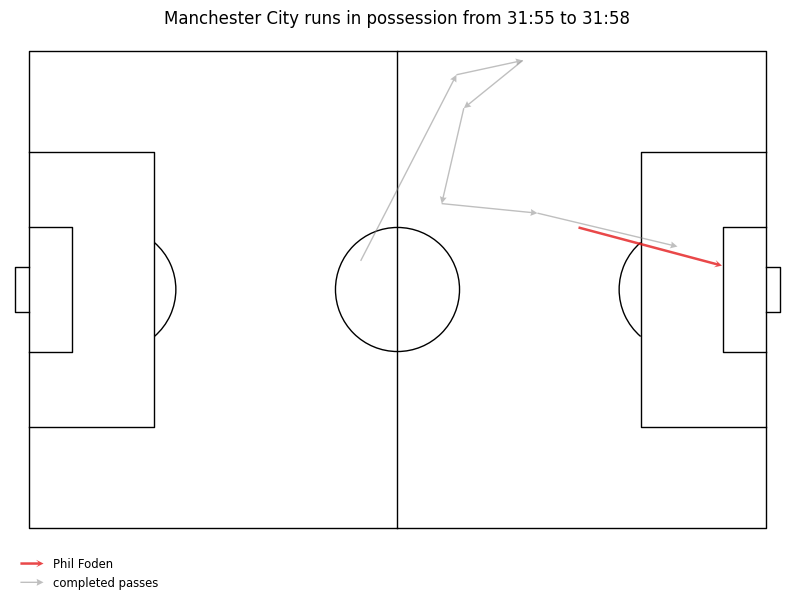

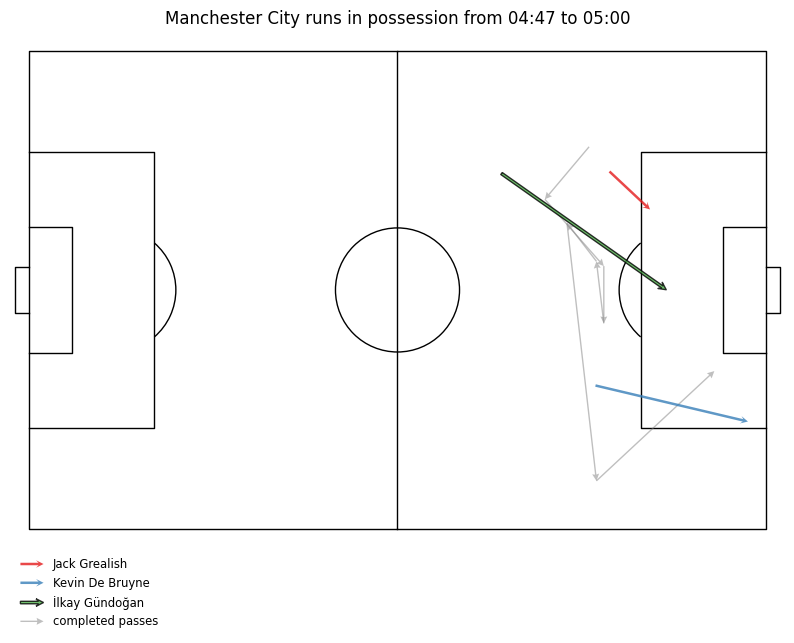

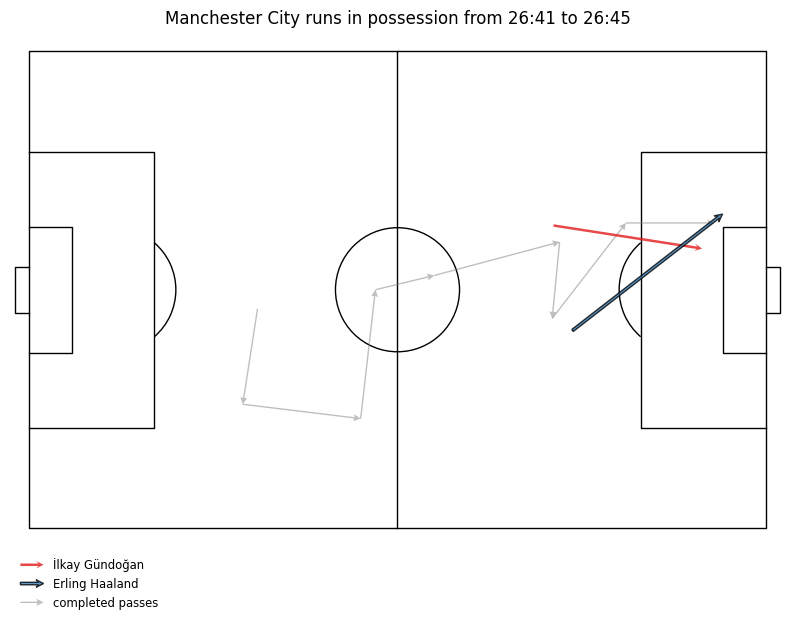

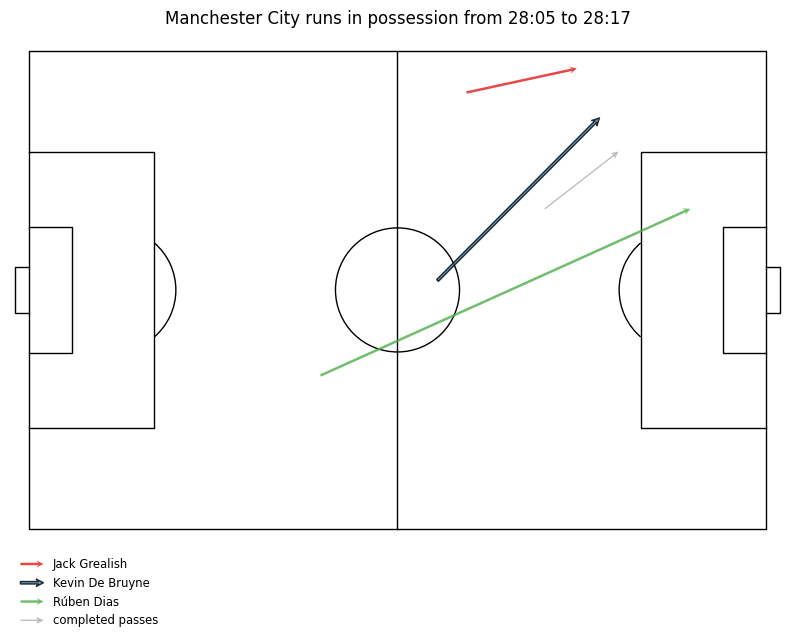

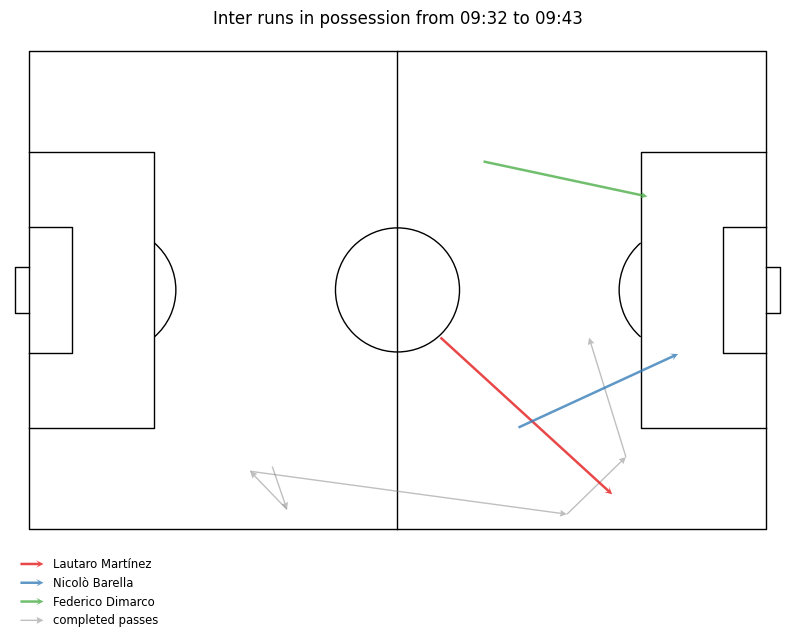

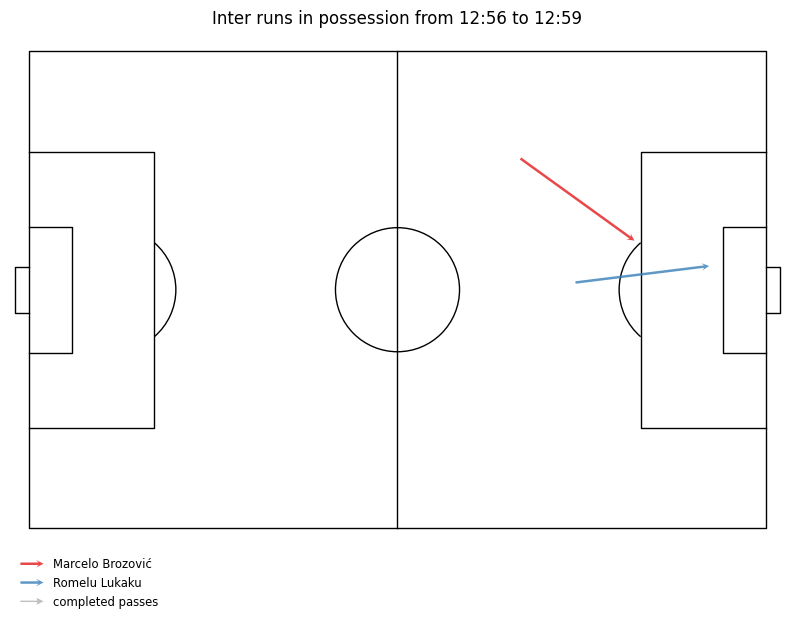

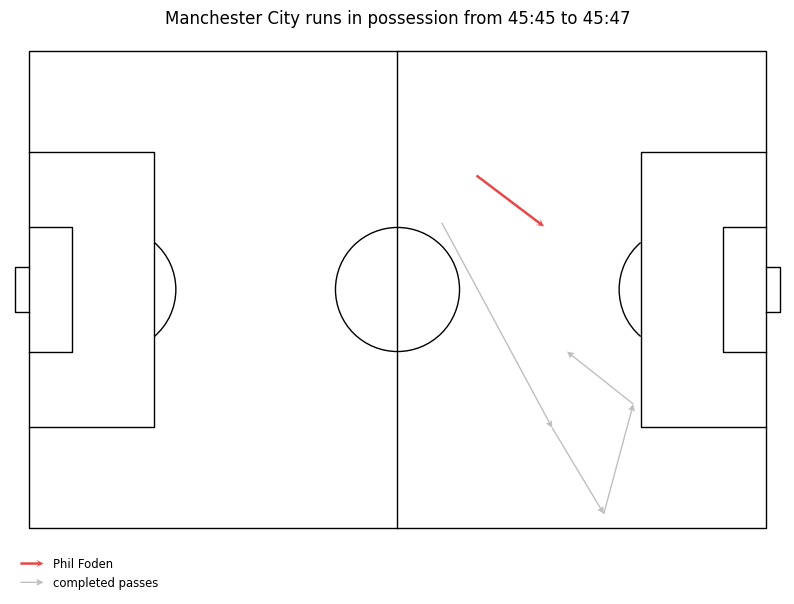

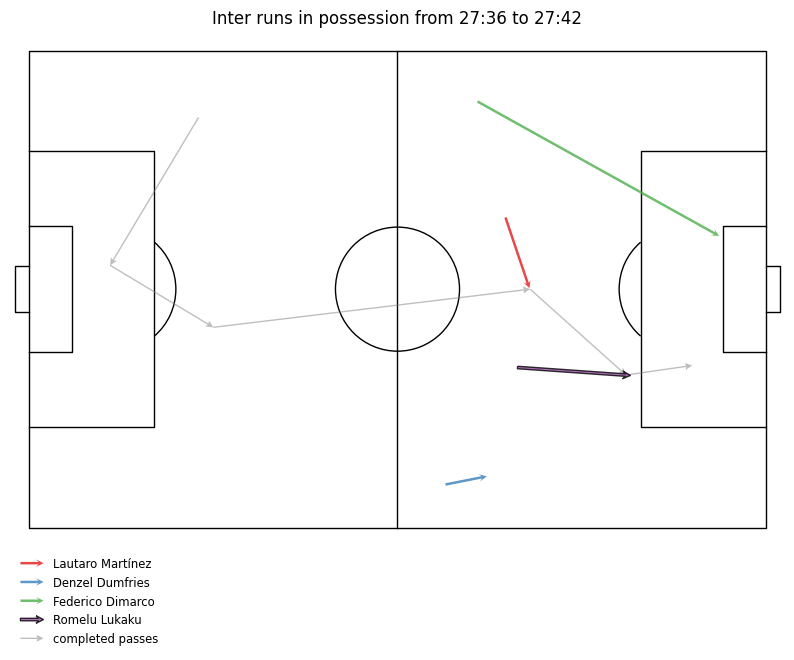

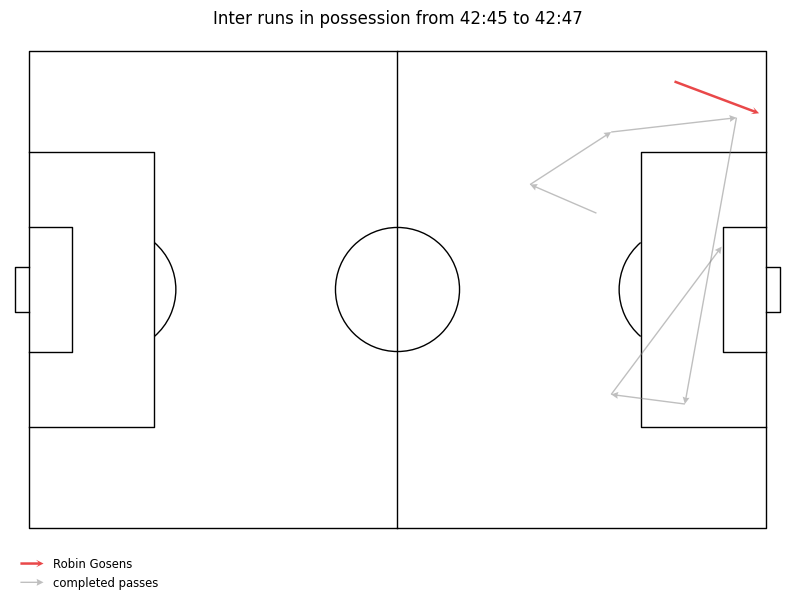

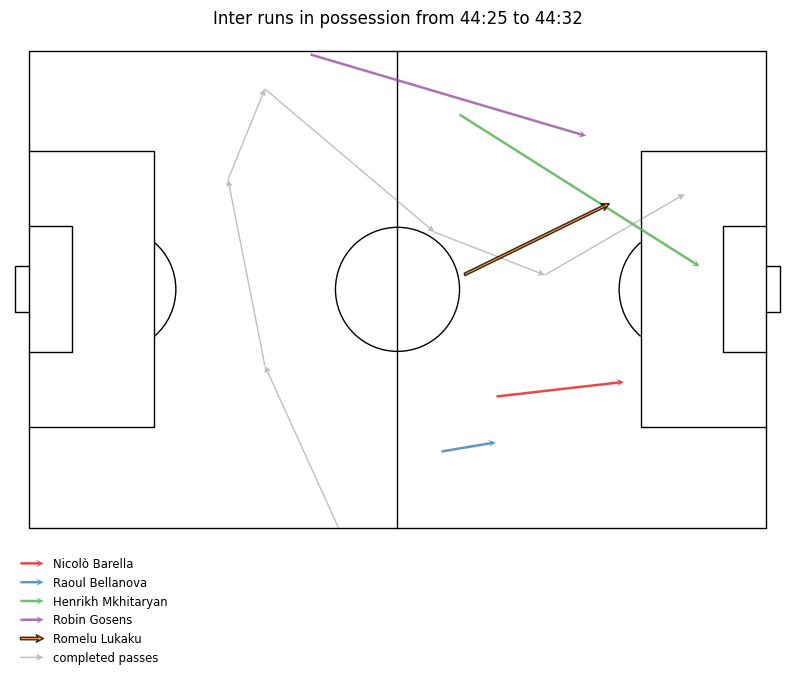

In [3]:
import pandas as pd  # 导入 pandas 用于数据操作
import os  # 用于文件和目录操作
from matplotlib import pyplot as plt  # 导入 matplotlib 用于绘制图形
from matplotlib.cm import get_cmap  # 从 matplotlib 导入 get_cmap，用于获取颜色映射
from mplsoccer import Pitch  # 从 mplsoccer 导入 Pitch 用于绘制足球场

"""
    Visualize runs - that were extracted from tracking data
"""

# 设置比赛的 ID，CL 决赛
match_id = 18768058

# 加载 wyscout 事件数据 - 坐标已转换为 opta 格式
df_events = pd.read_parquet(f"Data/{match_id}_stories.parquet")

# 加载预生成的 "runs" 数据
df_runs = pd.read_parquet(f"Data/{match_id}_runs.parquet")

# 查找所有在射门发生时拥有控球权的跑动
xg_runs = df_runs[df_runs['xGRun'] > 0]

# 将所有跑动分组到一个控球权中

visualize_passing_chain = True  # 是否可视化传球链
for possession_id, df_runs in xg_runs.groupby('possession_id'):

    # 获取控球权中的队伍事件
    df_possession = df_events[(df_events['possession_id'] == possession_id) & (df_events['possession_team_id'] == df_events['team_id'])]

    # 球员在一次控球中可能有多次跑动，仅保留其最后一次跑动
    df_runs = df_runs.drop_duplicates(subset='player', keep='last')

    # 绘制控球中的所有跑动
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
    pitch = Pitch(pitch_type="opta",  # 使用 opta 类型的球场
                  goal_type='box',  # 使用矩形球门
                  pitch_color="w",  # 设置球场颜色为白色
                  linewidth=1,  # 设置线条宽度为 1
                  spot_scale=0,  # 不绘制点球点
                  line_color="k",  # 线条颜色为黑色
                  line_zorder=1)  # 设置线条的绘制顺序

    # 绘制球场
    pitch.draw(ax)

    # 创建颜色集
    name = "Set1"  # 选择颜色集名称
    cmap = get_cmap(name)  # 获取颜色映射
    colors = cmap.colors  # 获取颜色列表
    counter = 0  # 颜色计数器

    # 绘制所有跑动
    for idx, row in df_runs.iterrows():

        # 可视化跑动
        pitch.arrows(row['start_x'], row['start_y'],  # 起点坐标
                          row['end_x'], row['end_y'],  # 终点坐标
                          width=1.8,  # 箭头宽度
                          headwidth=3, headlength=3, headaxislength=2,  # 箭头的头部尺寸
                          color=colors[counter],  # 颜色设置为当前计数器对应的颜色
                          edgecolor="k" if row['Target'] else colors[counter],  # 区分目标和非目标跑动
                          linewidth=1 if row['Target'] else 0,  # 区分目标和非目标跑动的边框宽度
                          alpha=0.8,  # 透明度
                          zorder=3,  # 设置绘制顺序
                          label=row['player'],  # 标签为球员名字
                          ax=ax)

        counter += 1  # 计数器加 1
        if counter >= len(colors):  # 如果计数器超出颜色列表长度，则重置为 0
            counter = 0

    # 可视化传球链
    if visualize_passing_chain:
        pitch.arrows(df_possession[df_possession['end_x'].between(1, 100)]['start_x'],  # 起点 x 坐标
                         df_possession[df_possession['end_x'].between(1, 100)]['start_y'],  # 起点 y 坐标
                         df_possession[df_possession['end_x'].between(1, 100)]['end_x'],  # 终点 x 坐标
                         df_possession[df_possession['end_x'].between(1, 100)]['end_y'],  # 终点 y 坐标
                         width=1, headwidth=5,  # 箭头宽度和头部宽度
                         alpha=0.5, ls='--', zorder=2,  # 透明度、线型和绘制顺序
                         headlength=5, color='grey', ax=ax, label='completed passes')  # 设置颜色、绘制的坐标轴和标签

    # 添加标题
    possession_start_time = df_runs['time_start'].min()[0:5]  # 控球开始时间
    possession_end_time = df_runs['time_end'].max()[0:5]  # 控球结束时间
    team_name = df_runs.iloc[0]['team_name']  # 获取队伍名称
    ax.set_title(f"{team_name} runs in possession from {possession_start_time} to {possession_end_time}")  # 设置图标题

    # 图例
    ax.legend(bbox_to_anchor=(0, 0), loc='upper left', fontsize='small', framealpha=0.0, ncol=1)  # 设置图例位置、字体大小等

    # 保存输出图像
    # os.makedirs("outputs", exist_ok=True)  # 如果不存在，则创建 "outputs" 目录
    # fig.savefig(f"outputs/runs_{possession_id}.jpg", format='jpg', dpi=200, facecolor=fig.get_facecolor())  # 保存图像到指定目录
